# Représentation intermédiaire

Miasm utilise une [représentation intermédiaire](https://en.wikipedia.org/wiki/Intermediate_representation) (*intermediate representation*, *IR*) pour abstraire les effets de bords d'un programme (comme LLVM par exemple). Les avantages étant :
* une représentation unique, quelque soit l'architecture de départ
* un *vocabulaire* minimaliste
* tous les effets de bords sont explicites (un *A + B* ne va pas mettre à jour des flags)

L'IR de Miasm est implémentée dans `miasm2.expression.expression`, sous forme d'`Expr*`. Une taille, en bits, leur est associée.

## Vocabulaire

Les mots les plus simples du vocabulaire sont :
* `ExprId` : représente un identifiant. Par exemple, le registre `EAX` sera représenté par un `ExprId` de 32 bits.
* `ExprInt` : représente un entier non signé.

In [1]:
from miasm2.expression.expression import *

a = ExprId("a", 32)
print a

# Accès à l'identifiant
print a.name

a
a


In [2]:
cst1 = ExprInt(16, 32)
print cst1
cst2 = ExprInt(-1, 32)
print cst2

# Accès à la valeur associée
print int(cst1)

0x10
0xFFFFFFFF
16


Ensuite, le mot `ExprMem` permet de représenter un accès mémoire, d'une taille définie en bit.

In [3]:
# Accès mémoire de 16 bits, à l'addresse 0x11223344 sur 32 bits
addr = ExprInt(0x11223344, 32)
mem1 = ExprMem(addr, 16)
print mem1

# Accès à l'addresse
print mem1.arg

@16[0x11223344]
0x11223344


Le mot `ExprOp` permet de définir des opérations n-aires entre expressions. L'opération est une chaîne de caractère, on peut donc en définir des nouvelles au besoin. Certaines opérations (`+`, `*`, `|`, `parity`, ...) sont déjà utilisées par Miasm. Une opération est toujours faite entre éléments de même taille, et a la taille de ses arguments.

In [4]:
# Définition d'une opération
op1 = ExprOp("+", a, cst1)
print op1

# Accès aux arguments
print op1.args

# Définition d'une opération custom
op2 = ExprOp("MyCustomOp", a)
print op2

a + 0x10
(ExprId('a', 32), ExprInt(0x10, 32))
MyCustomOp(a)


Des helpers sont présents pour faciliter la création de certaines opérations courantes

In [5]:
print a + cst1
print a * cst1
print - a
print a | cst1
print a & cst1

a + 0x10
a * 0x10
-a
a | 0x10
a & 0x10


Attention, même si les Expressions permettent de "tout" représenter, Miasm fait quelques hypothèses sur la représentation de certaines opérations :
* les opération associative (`+`, `^`, `|`, ...) sont des opérations n-aire
* le `-` est toujours unaire

In [6]:
print a - cst1

a + -0x10


* `parity` est toujours de taille 1, c'est une des rares exceptions

In [7]:
p = ExprOp("parity", a)
print a.size
print p.size

32
1


L'opération `=` est gérée à part, par un mot dédiée `ExprAff`.

In [8]:
assign = ExprAff(a, cst1)
print assign

# Source, destination
print assign.src
print assign.dst

a = 0x10
0x10
a


Le mot `ExprCond` permet de représenter une condition ternaire, équivalent au Python `src1 if cond else src2`

In [9]:
cond = ExprCond(a, cst1, cst2)
print cond

# Accès aux éléments
print cond.cond
print cond.src1
print cond.src2

a?(0x10,0xFFFFFFFF)
a
0x10
0xFFFFFFFF


La manipulation des tailles est faite grâce aux mots :
* `ExprSlice`: extraction d'un tranche de bits d'une expression
* `ExprCompose`: composition d'expression (comme un sandwich)

In [10]:
sl = ExprSlice(a, 6, 8)
print sl
print sl.size

# Accès aux éléments
print sl.arg
print sl.start
print sl.stop

# Forme plus simple
sl == a[6:8]

a[6:8]
2
a
6
8


True

In [11]:
# Représente la concaténation de a (bit 0 à 31) avec cst1 (bit 32 à 63)
comp = ExprCompose(a, cst1)
print comp
print comp.size

# Accès aux éléments
print comp.args
# Accès au bit de départ, et à l'argument associé
print list(comp.iter_args())

{a 0 32, 0x10 32 64}
64
(ExprId('a', 32), ExprInt(0x10, 32))
[(0, ExprId('a', 32)), (32, ExprInt(0x10, 32))]


Enfin, le mot `ExprLoc` permet de représenter un endroit (*location*) de la mémoire, du binaire, etc.
Par exemple, il permet de désigner la destination d'un saut ou d'un appel de fonction.

Un endroit est désigné par un élément unique (de type `LocKey`), qui peut être vu comme une clée permettant d'accèder aux autres infos liées à ce lieux : son offset, un nom ("main"), etc.
`ExprLoc` peut alors être vu comme un conteneur pour un `LocKey`.

In [14]:
loc = ExprLoc(LocKey(1), 32)
print loc

label_1


En résumé, les différents mots sont :

| Mot | Ecriture |
|-----|----------|
|ExprAff|A=B|
|ExprInt|0x18|
|ExprId|EAX|
|ExprLoc|label_1|
|ExprCond|A ? B : C|
|ExprMem|@16[ESI]|
|ExprOp|A + B|
|ExprSlice|AH = EAX[8 :16]|
|ExprCompose|AX = AH.AL|

## Helpers communs

In [15]:
# Masque de la bonne taille
a.mask

ExprInt(0xFFFFFFFF, 32)

In [16]:
# Taille de l'expression
a.size

32

In [17]:
# Version affichable
print a, cst1

a 0x10


In [18]:
# Représentation (pour pouvoir re-copier dans le code)
print repr(a), repr(a + cst1)

ExprId('a', 32) ExprOp('+', ExprId('a', 32), ExprInt(0x10, 32))


In [19]:
# Extension de taille (non signé, signé)
print cst1.zeroExtend(64)
print cst1.signExtend(64)

{0x10 0 32, 0x0 32 64}
{0x10 0 32, 0x10[31:32]?(0xFFFFFFFF,0x0) 32 64}


In [20]:
# Most significant bit
print a.msb()

a[31:32]


In [21]:
# Remplacement
expr1 = a + a + cst1
print expr1
expr2 = expr1.replace_expr({a: cst2})
print expr2

a + a + 0x10
0xFFFFFFFF + 0xFFFFFFFF + 0x10


In [22]:
# Test de type
print a.is_id()
print a.is_int()
print cst1.is_int()
print op1.is_op()
print op1.is_op("+")
print op1.is_op("&")

True
False
True
True
True
False


## Expression sous forme de graphe

Les expressions Miasm ont une structure récursive, et peuvent être représentée et manipulées sous la forme de graphe.
L'objet obtenu est un `DiGraph`, implémenté dans `miasm2.core.graph` et offrant les méthodes standards de manipulation de graphes (accès au noeuds, arrêtes, prédécesseurs, succésseurs, dominance, post-dominance, représentation en DOT, ...).

In [23]:
expr3 = a + cst1 & cst2
print expr3
graph = expr3.graph()
print graph

(a + 0x10) & 0xFFFFFFFF
0x10
(a + 0x10) & 0xFFFFFFFF
a + 0x10
a
0xFFFFFFFF
a + 0x10 -> a
a + 0x10 -> 0x10
(a + 0x10) & 0xFFFFFFFF -> a + 0x10
(a + 0x10) & 0xFFFFFFFF -> 0xFFFFFFFF


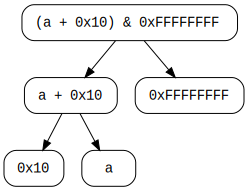

In [24]:
dot = graph.dot()
from graphviz import Source
src = Source(dot)
src

## Simplification d'expression

La simplification d'expression dans Miasm permet d'appliquer des règles de transformation à une expression, tant qu'il reste des règles appliquables.
Ce mécanisme est fait via un `ExpressionSimplifier`, implémenté dans `miasm2.expression.simplifications`.

Quelques règles de transformations basiques sont déjà présentes, et activées dans l'instance `expr_simp` du même module.

In [25]:
from miasm2.expression.simplifications import expr_simp

# 0x10 + (-1) = 0xF
op3 = cst1 + cst2
print op3
cst3 = expr_simp(op3)
print cst3

# 5ème bit de 0x10 = 1
sl2 = cst1[4:5]
print sl2
cst4 = expr_simp(sl2)
print cst4

# a + a - a = a
op4 = a + a - a
print op4
print expr_simp(op4)
assert expr_simp(op4) == a

# Utilisation pour évaluer une expression (ici, a + 0x10 évalué avec a = 0x10)
print op1
print op1.replace_expr({a: cst1})
print expr_simp(op1.replace_expr({a: cst1}))
print expr_simp(a + a +a + a)

0x10 + 0xFFFFFFFF
0xF
0x10[4:5]
0x1
a + a + -a
a
a + 0x10
0x10 + 0x10
0x20
a + a + a + a


Des règles de transformations peuvent être ajoutées, via `enable_passes`. Elles sont données sous la forme de fonction associées à un type d'expression.

Ci-dessous, on cherche à ajouter des passes permettant de transformer les expressions booléennes des conditions en opération du type `<`.
L'expression arithmético-booléenne correspondante est:

In [26]:
x = ExprId("x", 32)
y = ExprId("y", 32)

inf_signed = ((x - y) ^ ((x ^ y) & ((x - y) ^ x)))[31:32]
print inf_signed

def is_inf(x_val, y_val):
    new_val = expr_simp(inf_signed.replace_expr({
        x: x_val,
        y: y_val,
    }))
    assert new_val.is_int()
    return int(new_val) == 1

# 0 < 10
print is_inf(ExprInt(0, 32), ExprInt(10, 32))
# 10 !< 10
print is_inf(ExprInt(10, 32), ExprInt(10, 32))
# -1 < 0
print is_inf(ExprInt(0xFFFFFFFF, 32), ExprInt(0, 32))

((x + -y) ^ ((x ^ y) & ((x + -y) ^ x)))[31:32]
True
False
True


On ajoute les règles de transformations correspondantes (déjà implémentée dans le framework, mais non activées par défaut) :

In [27]:
from pprint import pprint as pp
from miasm2.expression.simplifications import ExpressionSimplifier
pp(ExpressionSimplifier.PASS_COND)

print expr_simp(inf_signed)
expr_simp_cond = ExpressionSimplifier()
expr_simp_cond.enable_passes(ExpressionSimplifier.PASS_COND)
print expr_simp_cond(inf_signed)

{<class 'miasm2.expression.expression.ExprCond'>: [<function expr_simp_equal at 0x7f0218bbd500>],
 <class 'miasm2.expression.expression.ExprSlice'>: [<function expr_simp_inf_signed at 0x7f0218bbd398>,
                                                    <function expr_simp_inf_unsigned_inversed at 0x7f0218bbd410>],
 <class 'miasm2.expression.expression.ExprOp'>: [<function exec_inf_unsigned at 0x7f0218bbd578>,
                                                 <function exec_inf_signed at 0x7f0218bbd668>,
                                                 <function expr_simp_inverse at 0x7f0218bbd488>,
                                                 <function exec_equal at 0x7f0218bbd6e0>]}
(((x ^ y) & (x ^ (x + -y))) ^ (x + -y))[31:32]
x <s y


### Exercice 1 : ajout d'une règle de transformation

Le but est maintenant d'ajouter notre propre règle de simplification, qui est la suivante (informellement) :

*Lors d'une addition n-aire entre termes égaux, on transforme cette addition en une multiplication du terme par *n.

Autrement dit, `a + a + a + a` devient `a * 4`.

Une règle de transformation se présente sous la forme d'une fonction, qui prend en paramètre :
* l'instance actuelle de l'`ExpressionSimplifier` utilisé (pour lancer des simplifications récursivement si besoin)
* l'expression à simplifier

La fonction doit **toujours retourner une expression**. Si elle ne fait aucun changement, elle retournera donc directement son deuxième argument.

Une règle de transformation doit retourner une *nouvelle* expression. En effet, les expressions de Miasm sont immutables, il faut donc recréer une nouvelle expression pour pouvoir appliquer une modification.

In [60]:
a = ExprId("a", 32)
cst1 = ExprInt(16, 32)

# Vecteurs de tests
tests = [
    # (entrée, sortie attendue)
    (a, a),
    (a + a, a * ExprInt(2, a.size)),
    (ExprOp("+", a, a, a, a), a * ExprInt(4, a.size)),
    (a + cst1, a + cst1),
    (a & cst1, a & cst1),
    (a[2:5] + a[2:5], a[2:5] * ExprInt(2, 3)),
]

# Vérification
def check(tests, custom_expr_simp):
    for inp, out in tests:
        print inp
        got = custom_expr_simp(inp)
        print got
        assert out == got

# TODO: Définition de la fonction
def masimplification(simp_engine, expr):
    if expr.is_op("+"):
        if len(set(expr.args)) == 1:
            return ExprOp("*", expr.args[0], ExprInt(len(expr.args), expr.size))
    return expr
# TODO: Création d'un ExpressionSimplifier
from miasm2.expression.simplifications import ExpressionSimplifier
simp_engine = ExpressionSimplifier()

simp_engine.enable_passes({
ExprOp: [masimplification]
})
# TODO: Ajout de la règle de transformation

# Lancement des tests
check(tests, simp_engine)

a
a
(a+a)
(a*0x2)
(a+a+a+a)
(a*0x4)
(a+0x10)
(a+0x10)
(a&0x10)
(a&0x10)
(a[2:5]+a[2:5])
(a[2:5]*0x2)


In [62]:
# Ajout d'un test un peu plus évolué

tests += [
    ((a + a) * ExprInt(5, a.size), a * ExprInt(10, a.size)),
]

# TODO: Activation des passes de propagation de constante
simp_engine.enable_passes(ExpressionSimplifier.PASS_COMMONS)

# Lancement des tests
check(tests, simp_engine)

a
a
(a+a)
(a*0x2)
(a+a+a+a)
(a*0x4)
(a+0x10)
(a+0x10)
(a&0x10)
(a&0x10)
(a[2:5]+a[2:5])
(a[2:5]*0x2)
((a+a)*0x5)
(a*0xA)
((a+a)*0x5)
(a*0xA)


Attention, dans certains cas, les passes de simplifications peuvent interagir.
Par exemple : 

In [ ]:
tests += [
    (a + a + a + a, a * ExprInt(4, a.size)),
]

check(tests, simp_engine)

Dans l'état actuel, le résultat obtenu devrait être :
`(a + a + (a * 2)`.

En effet, dans l'ordre de simplification :
1. `a + a + a + a = (a + (a + (a + a)))`, par construction
1. `(a + (a + (a * 2)))`, par simplification ajoutée ci-dessus
1. `(a + a + (a * 2))`, par la passe commune de transformation du `+` binaire en n-aire

À ce moment là, plus aucune règle ne matche, l'expression est donc finalement retournée.

Pour obtenir le résultat souhaité, ajouter la fonction de simplification suivante :

`X + .... + (X * int)`  est transformé en `.... + (X * (int + 1))`

In [ ]:
# TODO: nouvelle fonction de simplification

# TODO: enregistrement de la simplification

check(tests, TODO)

## Matching d'expression

Pour faciliter l'écriture de règle de transformation, Miasm embarque un mini moteur "d'expression régulière" sur les expressions, appelé `match_expr`.

Ses arguments sont :
* L'expression que l'on veut analyser
* Une expression décrivant ce que l'on veut matcher (le *pattern*)
* La liste des *jokers*, c'est à dire les expressions qui peuvent être remplacées dans le *pattern*

Par exemple, si l'on veut matcher l'expression `X + (X * Y) + EAX`, où `X` et `Y` sont des *placeholders*, on va utiliser :

`MatchExpr(expr_to_match, X + (X * Y) + EAX, [X, Y])`.

Le résultat est un dictionnaire associant chaque joker avec la sous-expression correspondante.
Il est capable de faire varier l'ordre des expressions lorsque l'opérateur est commutatif.

### Exercice 2 : Matching d'expression

Implémentez la règle de simplification suivante, à l'aide d'un MatchExpr :
`((x & y) + (x | y))` -> `(x + y)`

In [ ]:
from miasm2.expression.expression import match_expr

# Vecteur de tests
tests = [
    (((x & y) + (x | y)), (x + y)),
    (((x & y) + (x & y)), ((x & y) + (x & y))),
    (((cst1 >> a) | (a ^ cst1)) + (((a ^ cst1) & (cst1 >> a))), (cst1 >> a) + (a ^ cst1)),
]

# jokers
X = ExprId("X", 32)
Y = ExprId("Y", 32)



# TODO: règle de transformation
def masimplification(e_s, expr):
    result = match_expr(expr, ((X & Y) + (X | Y)), [X, Y])
    if result:
        return result[X] + result[Y]
    return expr
# TODO: création d'un ExpressionSimplifier

simp_engine.enable_passes({ExprOp: [masimplification]})
check(tests, simp_engine)

## Pour aller plus loin...

Quelques fonctionnalités relative aux expressions mais non détaillées ici (se référer aux exemples) :
* `SymbolicExecutionEngine` : émulation symbolique
* `Translators` : traduction des expressions vers du C, Python, "Miasm like", z3
* `expr_range` : Analyse du range de valeurs possibles d'une expression
* `AssignBlock`, `IRBlock`, `DiGraphDefUse`, `dead_simp`, ... : accumulation d'expression pour la description d'effet de bord d'un programme, et traitements associés
* `miasm2.arch.*.sem.py`, `SemBuilder` : description des sémantique des architectures, c'est à dire des effets de bords associés à un mnémonique